<h1><center>Modelling, Simulation and Optimisation (H9MSO) - Project</center></h1><h2><center>Vinaysheel Kishor Wagh (x18194303)</center></h2><h1><center>HS2 Line Simulation & Optimization</center></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Resource-Sharing" data-toc-modified-id="Resource-Sharing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Resource Sharing</a></span></li><li><span><a href="#Poisson-Distribution" data-toc-modified-id="Poisson-Distribution-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Poisson Distribution</a></span></li><li><span><a href="#Process-Scheduling" data-toc-modified-id="Process-Scheduling-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Process Scheduling</a></span></li><li><span><a href="#Simulation-Results" data-toc-modified-id="Simulation-Results-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Simulation Results</a></span></li></ul></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimization</a></span><ul class="toc-item"><li><span><a href="#Monte-Carlo-Optimization" data-toc-modified-id="Monte-Carlo-Optimization-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Monte-Carlo Optimization</a></span></li><li><span><a href="#Monte-Carlo-Optimization-result" data-toc-modified-id="Monte-Carlo-Optimization-result-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Monte-Carlo Optimization result</a></span></li><li><span><a href="#Customized-Optimization" data-toc-modified-id="Customized-Optimization-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Customized Optimization</a></span></li><li><span><a href="#Customized-Optimization-Result" data-toc-modified-id="Customized-Optimization-Result-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Customized Optimization Result</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

The proposed project is for the simulation and optimization of number of trains and passengers travelling on HS2 line from London to Birmingham using python. This project can help government in finalizing decision on the number of trains running per hour. First a simulation of the London-Birmingham section is designed using simpy library under assumptions of 14 signalling blocks and 9 number of trains running per hour. Then optimization techniques are used to minimize the number of signalling blocks and maximize the number of trains running per hour. The project is divided in different sections and each section describes a different phase of the project.  

## Libraries

All the required libraries are loaded into the kernel. Numpy, pandas are used for data processing, Simpy is used for simulation of trains and matplotlib is for visual representations.

In [9]:
#Load all the required libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
from numpy import random
import random

import simpy
import simpy.events as evt
import pulp

## Data Processing

For the implementation of this project a dataset is created based on the given assumptions and requirement and it is stored in a csv file. The dataset contains From, To, Distance, RunningTime, BlockTime, DwellTime and TotalBlock attributes. The data stored in csv file is extracted using pandas library. Distance between stations is converted into meter and running time, block time, dwell time is converted into seconds. Then using the distance and time, velocity as well as acceleration is calculated between two stations. 

In [10]:
#Calculate distance between stations and dwell time and insert it in dataset
#currently assuming random dwell time and approx distance.

#Load dataset
dt = pd.read_csv("mso.csv")

dt['Distance']=dt['Distance'].apply(lambda x: int(x*1000))
dt['RunningTime']=dt['RunningTime'].apply(lambda x: int(x*60))
dt['BlockTime']=dt['BlockTime'].apply(lambda x: int(x*60))
dt['DwellTime']=dt['DwellTime'].apply(lambda x: int(x*60))

dt

,Line,From,To,Distance,RunningTime,BlockTime,DwellTime,TotalBlock,StartSignal
0,HS2,London Euston,London Old Oak Common,25000,300,300,99,1,1
1,HS2,London Old Oak Common,Birmingham Interchange,145000,1860,204,90,11,2
2,HS2,Birmingham Interchange,Birmingham Curzon Street,55000,540,270,90,2,13


In [11]:
dt['a']=4*dt['Distance']/dt['RunningTime']**2

In [12]:
dt['v']=None
for i in range(len(dt)):
    t=dt.at[i,'RunningTime']
    d=dt.at[i,'Distance']
    a=dt.at[i, 'a']
    q=t**2*a**2/4-a*d
    if q<0:
        # corresponds to the case that the train never reaches v_max
        # it has to start decelerate half way through
        q=0
    dt.at[i, 'v']=t*a/2-np.sqrt(q)

dt.head()

,Line,From,To,Distance,RunningTime,BlockTime,DwellTime,TotalBlock,StartSignal,a,v
0,HS2,London Euston,London Old Oak Common,25000,300,300,99,1,1,1.111111,166.667
1,HS2,London Old Oak Common,Birmingham Interchange,145000,1860,204,90,11,2,0.167649,155.914
2,HS2,Birmingham Interchange,Birmingham Curzon Street,55000,540,270,90,2,13,0.754458,203.704


## Simulation

The simulation of HS2 line is performed under consideration of fixed drive time between two stations based on the acceleration and velocity of train between those stations. Signalling blocks and pre-signal checks are used between two stations for smooth and safe travel between two trains. Initially total 14 signalling blocks are considered and added between stations. Time between two trains is 399 seconds. This simulation of HS2 line gives an overview and a logical representation of number of trains running in an hour as well as number of passengers travelling on that trains. The simulation helps in designing the overall structure of the problem. 

### Model

The model consists of two classes Train and Signal. The train class contains all the details related to train such as stations, train type, capacity of train etc. also, it consist of a process() method which is used to start a train journey and after following all the constraints related to signalling block and time between trains, train reaches to its destination. It also contains getOff() and getOn() method which is used in embarkment and disembarkment of passengers.

In [13]:
class Train(object):
    def __init__(self,i,stations,maxPassengers,trainLength,data):
        #Initialize all the values required for a train to complete journey
        self.name = "<HS2> : Train "+f"{i+1:2d}"        
        self.trainNo = i
        self.route = stations
        self.p     = 0
        self.maxP  = maxPassengers
        self.trainLength = trainLength
        self.data = data
        
    def process(self):
        # code for starting the train journey        
        here = self.route[0]
        # The loop will iterate for each station of the journey
        for dest in self.route[1:]:
            #print("In process loop")
            #Extracting all the values from dataset
            self.data = dt[dt['Line'] == 'HS2'][dt['From']==here]
            #drivetime=data.iloc[0].at['DriveTime']
            dwelltime=self.data.iloc[0].at['DwellTime']
            blockTime =self.data.iloc[0].at['BlockTime']
            totalSignal =self.data.iloc[0].at['TotalBlock']
            signalNo = self.data.iloc[0].at['StartSignal']
            
            yield env.timeout(dwelltime) # timeout so that passenger can board on train
            
            self.getOn(self.maxP)        # Getting number of passengers boarding the train
            
            print(f"{now():s} {self.name:s} dep {here:s} for {dest:s}")
            #The instance of signal class is initiated to dynamically allocate signaling blocks to each train
            s = Signal(self.name,blockTime,here,totalSignal,signalNo,self.trainLength)   #Check signals
            yield env.process(s.process())   #creating a process interactor
            
            here=dest            
            print(f"{now():s} {self.name:s} arr {here:s}") # train reaches the destination
            
            self.getOff(random.choice(range(70,100)))     #This will return number of passenger getting off on that station
        #At last station everyone is getting off the train
        print(f"{now():s} {self.name:s} at Last station train is empty - {int(self.p):2d} passengers got off")
        self.p = 0
    
    # Code to get number of passengers getting on and getting off the train.
    def getOff(self, num): 
        # It will randomly return value between 70 &100 as assuming that many pasengers are getting off
        if self.p > num:              
            print(f"{now():s} {self.name:s} {int(num):2d} passengers got off")
            self.p -= num
        else:
            num = self.p
            print(f"{now():s} {self.name:s} train is empty - only {int(num):2d} passengers got off")
            self.p = 0

    def getOn(self, num):
        # Based on capacity of train(considering 70% of total capacity), allowing that many passengers to get on
        if (self.maxP is None) or (self.p + num <= self.maxP):
            print(f"{now():s} {self.name:s} {int(num):2d} passengers got on")
            self.p += num
        else:
            num = self.maxP - self.p
            print(f"{now():s} {self.name:s} train is full - only {int(num):2d} passengers got on")
            self.p = self.maxP
    
    
           
            

The signal class contains details related to signalling block. Signalling blocks are made up of pre-signals, signals, number of blocks between stations. This class also encapsulates process() method which works on allocating signalling block for each train based on its availability.

In [14]:
class Signal(object):
    def __init__(self,name,blockTime,here,totalSignal,signalNo,trainLength):
        #This will initialize all the details required for a signaling block
        self.name = name
        self.blockTime = blockTime
        self.here=here
        self.totalSignal=totalSignal
        self.signalNo = signalNo
        self.trainLength = trainLength
        
    def process(self):        
        for i in range(self.totalSignal):
            if self.here == "London Euston":
                #Creating a resource having capacity = totalSignal block between London Euston & London Old Oak Common
                numberOfSignal = simpy.Resource(env,capacity=self.totalSignal)
                #process containing created resources
                yield env.process(checkFirstBlockSignal(numberOfSignal,self.name,self.signalNo,self.blockTime,self.trainLength))
            elif self.here == "London Old Oak Common":
                #Creating a resource having capacity = totalSignal block between London Old Oak Common & Birmingham Interchange
                numberOfSignal = simpy.Resource(env,capacity=self.totalSignal)
                #process containing created resources
                yield env.process(checkSecondBlockSignal(numberOfSignal,self.name,self.signalNo,self.blockTime,self.trainLength))
            else:
                #Creating a resource having capacity = totalSignal block between Birmingham Interchange & Birmingham Curzon Street
                numberOfSignal = simpy.Resource(env,capacity=self.totalSignal)
                #process containing created resources
                yield env.process(checkThirdBlockSignal(numberOfSignal,self.name,self.signalNo,self.blockTime,self.trainLength)) 
                                
            self.signalNo += 1


### Resource Sharing

Resource sharing mechanism of simpy is followed in the project for dynamic allocation of signalling blocks of the trains. The signalling blocks are divided into three groups, first group of resource is for blocks between station 1 & 2, second is for blocks between 2 & 3, third resource accommodates blocks between station 3 & 4. The train can move further, if it gets a resource (signalling block) otherwise it has to wait until resource gets free. When train is inside a block then signal for that block is red and signal gets green after 5 seconds delay, once a train leaves the block. 

In [15]:
def checkFirstBlockSignal(numberOfSignal,name,signalNo,blockTime,trainLength):
    #The method will allocate signaling block between London Euston and London Old Oak Common
    timeToEnterBlock = (blockTime/trainLength)*10        #time taken by a train to enter in a signaling block 
    timeToPreSignalCheck = (blockTime/3)-timeToEnterBlock#time taken by a train to reach pre-signal check of next block 
    timeToEndBlock = blockTime - timeToPreSignalCheck    # time require to cover the remaining block from pre-signal check
    
    #Generates a event that will wait until resource is free
    with numberOfSignal.request() as req:
        yield req
        #once a train gets resource (signaling block) the train starts running and covers signaling block based on following timeline
        print(f"{now():s} {name:s} Entering signaling block -{signalNo:2d} entry signal status - Green")
        yield env.timeout(timeToEnterBlock) # timeout untill train enters in a signaling block
        print(f"{now():s} {name:s} Inside signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(timeToPreSignalCheck) # time required by train to reach a signaling block       
        print(f"{now():s} {name:s} pre-signal check for block -{signalNo+1:2d} pre-signal status - Green")
        yield env.timeout(timeToEndBlock) #time to reach end of block
        print(f"{now():s} {name:s} Left signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(5)   # 5 second timeout after train leaves a block 
        print(f"{now():s} {name:s} signaling block -{signalNo:2d} entry signal status - Green")

def checkSecondBlockSignal(numberOfSignal,name,signalNo,blockTime,trainLength):
    #The method will allocate signaling block between London Old Oak Common and Birmingham Interchange
    timeToEnterBlock = 0
    # time to enter in a block from a station varies based on its lenght next if-else loop will calculate time based on its length
    if(signalNo == 2):
        timeToEnterBlock = (blockTime/trainLength)*10
    else:
        timeToEnterBlock = (blockTime/trainLength)*5
    timeToPreSignalCheck = (blockTime/3)-timeToEnterBlock #time taken by a train to reach pre-signal check of next block
    timeToEndBlock = blockTime - timeToPreSignalCheck     #time require to cover the remaining block from pre-signal check
    #Generates a event that will wait until resource is free
    with numberOfSignal.request() as req:
        yield req     
        #once a train gets resource (signaling block) the train starts running and covers signaling block based on following timeline
        print(f"{now():s} {name:s} Entering signaling block -{signalNo:2d} entry signal status - Green")
        yield env.timeout(timeToEnterBlock) #time for train to enter inside block
        print(f"{now():s} {name:s} Inside signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(timeToPreSignalCheck)        # time required by train to reach a signaling block
        print(f"{now():s} {name:s} pre-signal check for block -{signalNo+1:2d} pre-signal status - Green")
        yield env.timeout(timeToEndBlock)       #time to reach end of block
        print(f"{now():s} {name:s} Left signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(5)   # 5 second timeout after train leaves a block 
        print(f"{now():s} {name:s} signaling block -{signalNo:2d} entry signal status - Green")


def checkThirdBlockSignal(numberOfSignal,name,signalNo,blockTime,trainLength):
    #The method will allocate signaling block between Birmingham Interchange and Birmingham Curzon Street
    timeToEnterBlock = 0
    # time to enter in a block from a station varies based on its lenght next if-else loop will calculate time based on its length
    if(signalNo == 2):
        timeToEnterBlock = (blockTime/trainLength)*10
    else:
        timeToEnterBlock = (blockTime/trainLength)*5
    timeToPreSignalCheck = (blockTime/3)-timeToEnterBlock #time taken by a train to reach pre-signal check of next block
    timeToEndBlock = blockTime - timeToPreSignalCheck     #time require to cover the remaining block from pre-signal check
    #Generates a event that will wait until resource is free
    with numberOfSignal.request() as req:
        yield req        
        #once a train gets resource (signaling block) the train starts running and covers signaling block based on following timeline
        print(f"{now():s} {name:s} Entering signaling block -{signalNo:2d} entry signal status - Green")
        yield env.timeout(timeToEnterBlock) #time for train to enter inside block
        print(f"{now():s} {name:s} Inside signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(timeToPreSignalCheck)        #time required by train to reach a signaling block
        print(f"{now():s} {name:s} pre-signal check for block -{signalNo+1:2d} pre-signal status - Green")       
        yield env.timeout(timeToEndBlock)       #time to reach end of block
        print(f"{now():s} {name:s} Left signaling block -{signalNo:2d} entry signal status of block{signalNo:2d} - Red")
        yield env.timeout(5)   # 5 second timeout after train leaves a block 
        print(f"{now():s} {name:s} signaling block -{signalNo:2d} signal status - Green")


### Poisson Distribution

The number of passengers arriving at a station per hour is not given so, poisson distribution can return number of passengers arriving at a station. Poisson distribution will select m number of passengers arriving at a station in one hour. The lam is calculated by assuming 10 short trains are running per hour and it can accommodate up to 4200 passengers. This function will return randomly selected value given by poisson distribution.

In [34]:
#Loading again as it gives error random not found
from numpy import random
def poissonDist():
    #randomly seelcting number of passengers arriving at a station
    x = random.choice(random.poisson(lam=4700, size=10))
    return x
#poissonDist()

In [17]:
def daytime(t):
    #Getting daytime in required format
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)

### Process Scheduling

This method is creating a object of class train and scheduling the journey of that train by calling process() function of the same class. The time between two train is calculated by combining drive time in first block, dwell time at second station and length of train. So, it will basically serve all the request of train scheduling and passenger allocation. The length of train is not fixed so, it is randomly selected for each train using getTrainLenght() method. 
The capacity of train varies based on their lenght and each train can carry 70% passengers of its nominal capacity. So, for each train maximum number of passengers is calculated using getTrainDetails() method. Also based on the length of train time between train varies and it is also return by the function getTrainDetails(). 

In [18]:
def server(totalTrains,data, start=6*3600, stop=7*3600):
    #the code to start journey of each train
    #Extracting required data from dataset
    stations=data['From'].to_list()
    stations+=[data['To'].to_list()[-1]]
    trainLength = getTrainLength() #Getting length of train (200 or 300)
    maxPassenger, timeBetnTrain = getTrainDetails(trainLength) #Getting cpacity of train and time require to depart from 2nd station
    passengerCount = poissonDist() #number of passengers in station per hour
    print(f"{passengerCount:2d} passengers will be arriving at station in one hour")
    passengersRemaining = passengerCount
    for i in range(int(totalTrains)):
        #Creating a instance of train class for each train
        t=Train(i, stations,maxPassenger,trainLength,data)
        env.process(t.process())        
        yield env.timeout(timeBetnTrain) #time between two trains
        trainLength = getTrainLength()
        maxPassenger, timeBetnTrain = getTrainDetails(trainLength)
        passengersRemaining = passengersRemaining - maxPassenger #Calculating passengers available at station after each train
    yield env.timeout(stop-start) # the process will reun for one hour
    print(f"Total {(passengerCount - passengersRemaining):2d} travlled on HS2 line in one hour")

In [19]:
def getTrainLength():
    # Randomly trains are selected from short and big and returned 
    trainLength = [200,300]
    return random.choice(trainLength)

def getTrainDetails(trainLength):
    #Based on the lenght of train calculating capacity of train and time between trains
    if trainLength == 200:
        maxPassenger = int(420*0.7) #Considering 70% of total capacity as train capacity
        timeBetnTrain = dt.iloc[0].at['BlockTime'] + dt.iloc[0].at['DwellTime'] #time require to coverthe block and dwell time 
    else:
        maxPassenger = int(630*0.7) #Considering 70% of total capacity as train capacity
        timeBetnTrain = dt.iloc[0].at['BlockTime'] + dt.iloc[0].at['DwellTime'] + 5 #time require to coverthe block and dwell time + 5 seconds for long train
    return maxPassenger, timeBetnTrain

### Simulation Results

The simpy environment is created initially and then simulation starts by calling simpy process() method. The server() method is given as argument which will schedule all the given trains. Number of trains and all the details related to the train journey from London to Birmingham is given as parameter to the function. 

The output of simulation shows the scheduling of trains per hour. Also, it demonstrates the trains behaviour in signalling blocks using resource sharing. The first train is starting at 00:01:39 and then after 399 seconds, second train starts its journey. Also, the last train is departing within an hour at 00:55:11 after 1st train departs from first station. There are total 4786 passengers arriving at station in an hour and the proposed model is capable of travelling 3381 passengers. 

In [20]:
env = simpy.Environment()

In [21]:
totalTrains = 9 #assuming value, initially tried it multiple time with simulation and then fixed it to 10 as that many trains are running smoothly
env.process(server(totalTrains,dt)) #passing number of train and dataset of London to Birmingham journey
env.run()

4786 passengers will be arriving at station in one hour
00:01:39 <HS2> : Train  1 441 passengers got on
00:01:39 <HS2> : Train  1 dep London Euston for London Old Oak Common
00:01:39 <HS2> : Train  1 Entering signaling block - 1 entry signal status - Green
00:01:49 <HS2> : Train  1 Inside signaling block - 1 entry signal status of block 1 - Red
00:03:19 <HS2> : Train  1 pre-signal check for block - 2 pre-signal status - Green
00:06:49 <HS2> : Train  1 Left signaling block - 1 entry signal status of block 1 - Red
00:06:54 <HS2> : Train  1 signaling block - 1 entry signal status - Green
00:06:54 <HS2> : Train  1 arr London Old Oak Common
00:06:54 <HS2> : Train  1 70 passengers got off
00:08:23 <HS2> : Train  2 294 passengers got on
00:08:23 <HS2> : Train  2 dep London Euston for London Old Oak Common
00:08:23 <HS2> : Train  2 Entering signaling block - 1 entry signal status - Green
00:08:24 <HS2> : Train  1 train is full - only 70 passengers got on
00:08:24 <HS2> : Train  1 dep London Ol

01:14:16 <HS2> : Train  6 signaling block -10 entry signal status - Green
01:14:16 <HS2> : Train  6 Entering signaling block -11 entry signal status - Green
01:14:21 <HS2> : Train  6 Inside signaling block -11 entry signal status of block11 - Red
01:14:25 <HS2> : Train  8 pre-signal check for block - 8 pre-signal status - Green
01:14:54 <HS2> : Train  7 pre-signal check for block -10 pre-signal status - Green
01:15:10 <HS2> : Train  4 pre-signal check for block -15 pre-signal status - Green
01:15:24 <HS2> : Train  6 pre-signal check for block -12 pre-signal status - Green
01:15:44 <HS2> : Train  5 train is full - only 88 passengers got on
01:15:44 <HS2> : Train  5 dep Birmingham Interchange for Birmingham Curzon Street 
01:15:44 <HS2> : Train  5 Entering signaling block -13 entry signal status - Green
01:15:49 <HS2> : Train  5 Inside signaling block -13 entry signal status of block13 - Red
01:16:03 <HS2> : Train  9 Left signaling block - 5 entry signal status of block 5 - Red
01:16:08 

## Optimization

The simulation is created based on assumptions related to number of blocks and number of trains running per hour. The optimization techniques returns the optimal output. So, to get an optimal solution valid details are required. This section demonstrates the optimization methods used in proposed project to get best results.

### Monte-Carlo Optimization

Monte-Carlo optimization technique is used in project to minimize average travelling time by optimizing number of trains running per hour and number of blocks between station London Old Oak Common & Birmingham Interchange. In this method average travelling time for passenger is minimized. As average trvelling time includes waiting time for next train and actual travelling time between two stations. So, a objective function is defined which consist of average traveling time, average waiting time and dwell time. Then different values generated using monte_carlo() function based on probability distribution is checked against the objective function to get minimized average traveling time. 

In [22]:
#Objective Function 1
def f(x,y):
    return ((5+(2.58*x)+9)+(0.5*60/y)+(1.5*2)) 

In [23]:
#import random
random.seed(0)

In [24]:
def monte_carlo(n, xmin=9, xmax=12, ymin=1, ymax=10):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    for i in range(1, len(x)):
        fi = f(x[i], y[i])
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
    xs = np.linspace(xmin, xmax, 100)
    ys = np.linspace(ymin, ymax, 100)
    xx, yy = np.meshgrid(xs, ys)
    z=f(xx, yy)
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(xs, ys, z, 100)
    fig.colorbar(cs, ax=ax)
    plt.scatter(x, y, c='red', marker='.')
    plt.plot(xp, yp, c='red')
    return len(xp), xp[-1], yp[-1], f(xp[-1], yp[-1])

(2, 10, 9, 43.53333)


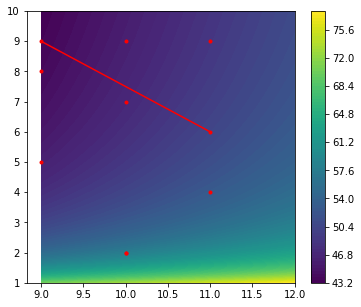

In [25]:
random.seed(65)
res = monte_carlo(10)
print(res)

### Monte-Carlo Optimization result 

The monte-carlo optimization is returning that, 10 trains can travel in one hour and there can be 8 blocks between station London Old Oak Common and Birmingham Interchange. And with this many trains and blocks the average travelling time is minimized to 48.99 minute. So this result is passed as input to the simulation for evaluation of simulation flow.

In [26]:
optNumberOfTrain = res[1] #storing number of trains returned by optimization function
optNumberOfBlock = res[2] #storing number of blocks returned by optimization function

In [27]:
#Loading the optimization results in dataset
data = dt[dt['Line'] == "HS2"]
data.loc[data['From'] == 'London Old Oak Common','TotalBlock'] = optNumberOfBlock

The output shows that 10 trains are travelling in an hour and accomodating 3969 passengers. This result is more efficient as compare to the first simulation output as now more trains are running in an hour and more number of passengers are travelling.

The result is showing the enhancement in number of trains running per hour because now 10 trains can run in one hour. The optimization is correctly minimizing the average travelling time

In [28]:
env = simpy.Environment()
env.process(server(optNumberOfTrain,data))
env.run()

4812 passengers will be arriving at station in one hour
00:01:39 <HS2> : Train  1 441 passengers got on
00:01:39 <HS2> : Train  1 dep London Euston for London Old Oak Common
00:01:39 <HS2> : Train  1 Entering signaling block - 1 entry signal status - Green
00:01:49 <HS2> : Train  1 Inside signaling block - 1 entry signal status of block 1 - Red
00:03:19 <HS2> : Train  1 pre-signal check for block - 2 pre-signal status - Green
00:06:49 <HS2> : Train  1 Left signaling block - 1 entry signal status of block 1 - Red
00:06:54 <HS2> : Train  1 signaling block - 1 entry signal status - Green
00:06:54 <HS2> : Train  1 arr London Old Oak Common
00:06:54 <HS2> : Train  1 78 passengers got off
00:08:23 <HS2> : Train  2 441 passengers got on
00:08:23 <HS2> : Train  2 dep London Euston for London Old Oak Common
00:08:23 <HS2> : Train  2 Entering signaling block - 1 entry signal status - Green
00:08:24 <HS2> : Train  1 train is full - only 78 passengers got on
00:08:24 <HS2> : Train  1 dep London Ol

01:12:44 <HS2> : Train  9 Inside signaling block - 5 entry signal status of block 5 - Red
01:12:57 <HS2> : Train  8 Left signaling block - 6 entry signal status of block 6 - Red
01:13:02 <HS2> : Train  8 signaling block - 6 entry signal status - Green
01:13:02 <HS2> : Train  8 Entering signaling block - 7 entry signal status - Green
01:13:05 <HS2> : Train  8 Inside signaling block - 7 entry signal status of block 7 - Red
01:13:18 <HS2> : Train  7 Left signaling block - 8 entry signal status of block 8 - Red
01:13:23 <HS2> : Train  7 signaling block - 8 entry signal status - Green
01:13:23 <HS2> : Train  7 Entering signaling block - 9 entry signal status - Green
01:13:26 <HS2> : Train  7 Inside signaling block - 9 entry signal status of block 9 - Red
01:13:28 <HS2> : Train 10 pre-signal check for block - 4 pre-signal status - Green
01:13:49 <HS2> : Train  9 pre-signal check for block - 6 pre-signal status - Green
01:14:02 <HS2> : Train  4 Left signaling block -13 entry signal status of 

### Customized Optimization 

To maximize the number of passengers travelling on HS2 line a customized objective function is defined, which takes number of trains as parameter. I have defined this method by considering all the requirements related to number of passengers. For maximizing total passengers travelling in an hour we must maximize the capacity of train. In the monte-carlo optimization results we are getting the optimize number of trains and based on this count this optimization function will return how many short train and long train can be used on HS2 line to maximize the throughput of passengers travelling. 

In this optimization function selection of train is performed based on comparison of the capacity of train and number of passengers waiting at a train station (using poisson distribution for getting number of passengers). Finally, the objective function will return count of short train and long train.

In [32]:
def obj(numberOfTrain):
    #Extracting required data from dataset
    data = dt[dt['From']=="London Euston"]
    dwellTime = data.iloc[0].at['DwellTime']
    firstBlockTime = data.iloc[0].at['BlockTime']
    #getting number of passenger waiting at a station using poisson distrivbution
    paasengerAtStation = poissonDist()
    totalPassenger = paasengerAtStation
    #print(f"{paasengerAtStation:2d} passengers waiting at station")
    passengersTravelling, timeToBoard = 0,0
    
    #Calculating capacity of train by considering 70% of space only available for passengers
    shortTrainCapacity = int(420*0.7)
    longTrainCapacity = int(630*0.7)
    #creating two variables for storing train type sTrain is short train and lTrain is long train
    sTrain,lTrain = 0, 0
    
    for i in range(numberOfTrain):
        passengersTravelling = 0
        if paasengerAtStation <= 0: # breaking the loop if there are no passengers waiting at station
            break
        #Based on comparison of passengers waiting at station and train capacity selecting a train type
        if paasengerAtStation < longTrainCapacity:
            if paasengerAtStation <shortTrainCapacity:
                sTrain += 1 #selecting short train
                passengersTravelling += paasengerAtStation
            else:
                sTrain += 1 #selecting short train
                passengersTravelling += shortTrainCapacity
        else:
            lTrain += 1 #selecting long train
            passengersTravelling += longTrainCapacity
        paasengerAtStation = paasengerAtStation - passengersTravelling #passengers waiting at station 
    return sTrain, lTrain # finally returning the train type

### Customized Optimization Result

The optimization function returned 1 short train and 9 long train can be used on HS2 line to carry maximum number of passengers. Below cell represents the output of customized optimization function.  

In [33]:
trainType = list(obj(optNumberOfTrain)) #Calling objective function
print(f"Short train - {trainType[0]:2d} & Long train - {trainType[1]:2d}") #result

Short train -  1 & Long train -  9


Now, we will again simulate the flow using simulation part of the project. First, creating a simpy environment and then creating a process for server method. The getTrainLength() function is defined again so that it can return the length of trains based on the output of the optimization function.

In [35]:
def getTrainLength():
    # selecting train type based on optimization results
    #print(trainType[0])
    if trainType[0] == 1:
        trainType[0] = 0
        return 200
    else:        
        return 300

Below simulation output shows that 4410 passengers can travel on HS2 line. This shows that the throghput of passengers travelling is maximized by using the above optimization function.

In [36]:
env = simpy.Environment()
env.process(server(optNumberOfTrain,data))
env.run()

4716 passengers will be arriving at station in one hour
00:01:39 <HS2> : Train  1 294 passengers got on
00:01:39 <HS2> : Train  1 dep London Euston for London Old Oak Common
00:01:39 <HS2> : Train  1 Entering signaling block - 1 entry signal status - Green
00:01:54 <HS2> : Train  1 Inside signaling block - 1 entry signal status of block 1 - Red
00:03:19 <HS2> : Train  1 pre-signal check for block - 2 pre-signal status - Green
00:06:54 <HS2> : Train  1 Left signaling block - 1 entry signal status of block 1 - Red
00:06:59 <HS2> : Train  1 signaling block - 1 entry signal status - Green
00:06:59 <HS2> : Train  1 arr London Old Oak Common
00:06:59 <HS2> : Train  1 88 passengers got off
00:08:18 <HS2> : Train  2 441 passengers got on
00:08:18 <HS2> : Train  2 dep London Euston for London Old Oak Common
00:08:18 <HS2> : Train  2 Entering signaling block - 1 entry signal status - Green
00:08:28 <HS2> : Train  2 Inside signaling block - 1 entry signal status of block 1 - Red
00:08:29 <HS2> : 

01:00:52 <HS2> : Train  6 pre-signal check for block - 8 pre-signal status - Green
01:01:13 <HS2> : Train  5 pre-signal check for block -10 pre-signal status - Green
01:01:34 <HS2> : Train  4 pre-signal check for block -12 pre-signal status - Green
01:01:42 <HS2> : Train  2 pre-signal check for block -15 pre-signal status - Green
01:02:10 <HS2> : Train 10 441 passengers got on
01:02:10 <HS2> : Train 10 dep London Euston for London Old Oak Common
01:02:10 <HS2> : Train 10 Entering signaling block - 1 entry signal status - Green
01:02:11 <HS2> : Train  9 train is full - only 77 passengers got on
01:02:11 <HS2> : Train  9 dep London Old Oak Common for Birmingham Interchange
01:02:11 <HS2> : Train  9 Entering signaling block - 2 entry signal status - Green
01:02:16 <HS2> : Train  3 train is full - only 76 passengers got on
01:02:16 <HS2> : Train  3 dep Birmingham Interchange for Birmingham Curzon Street 
01:02:16 <HS2> : Train  3 Entering signaling block -13 entry signal status - Green
01:

## Conclusion

The project has successfully implemented simulation and optimization of London to Birmingham HS2 line. The simulation was developed by assuming the number of trains, number of signalling blocks and type of trains. The output of simulation was not optimized. So, optimization techniques are used in the project to get optimal output from the simulation. The monte-carlo optimization techniques maximized the number of trains and minimized the average travelling time. Customized optimization method has maximized the throughput of passengers travelling on HS2 line. Finally, 10 trains can travel on HS2 line in an hour and approximately 4410 max passenger can travel using this trains. Now, it will get easy for the government to make decision on number of trains running on HS2 line based on the proposed project.

## References

[1] “SimPy in 10 Minutes” [Online]. Available: https://simpy.readthedocs.io/en/latest/simpy_intro/index.html.

[2] D. ByongKyuChoi, Modeling and Simulation of Discrete Event Systems, Wiley, 2013. 

[3] W. L. C. W. J.-P. W. D. H. G. N. B. S. J. Hart, Pymo - Optimization Modeling in Python, Springer, 2017. 

[4] a. E. Osais, Computer Simulation: A Foundational Approach Using Python, CRC Press. 

[5] A. B. D. E. N. K. R.-M. S. Ehsan Hashemi Petroodi, "Simulation-based optimization approach with scenario-based product         sequence in a reconfigurable manufacturing system (RMS): A case study," IFAC-PapersOnLine, vol. 52, no. 13, pp. 2638-2643,     2019. 